# Lion et Tigre Mask-MRCNN

In [4]:
pwd

'C:\\M1 MASERTI\\GPIA\\IA\\environnement_virtuel\\Mask_RCNN-master'

**Ce code initialise nos importations et définit les chemins nécessaires pour préparer l'entraînement ou l'inférence avec Mask R-CNN, en organisant notre projet pour la segmentation d'images :**

In [4]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

#import custom

# Root directory of the project
ROOT_DIR = r"C:/M1 MASERTI/GPIA/IA/environnement_virtuel/Mask_RCNN-master"

DEFAULT_LOGS_DIR = r"C:/M1 MASERTI/GPIA/IA/environnement_virtuel/Mask_RCNN-master/logs"

MODEL_DIR = r"C:/M1 MASERTI/GPIA/IA/environnement_virtuel/Mask_RCNN-master/logs"


WEIGHTS_PATH = r"C:/M1 MASERTI/GPIA/IA/environnement_virtuel/Mask_RCNN-master/logs/object20241103T1520/mask_rcnn_object_0001.h5"   # change it

**La classe CustomConfig sert à régler les hyperparamètres du modèle Mask R-CNN. Les hyperparamètres sont des valeurs que nous définissons avant l'entraînement et qui influencent directement les performances du modèle, son efficacité en termes de calcul, et sa capacité à bien généraliser sur de nouvelles données.**

**Voici un résumé de chaque paramètre dans la classe CustomConfig :**

NAME = "object" : Ce nom identifie la configuration, utilisé pour organiser les fichiers de logs et les sauvegardes de modèle. Ici, le modèle est nommé "object".

IMAGES_PER_GPU (batch size) = 1 : Définit le nombre d'images traitées par GPU à chaque étape. Mettre 1 limite la charge sur la mémoire GPU, ce qui est utile pour les configurations avec peu de mémoire graphique.
Un GPU (Graphics Processing Unit) est une unité de traitement graphique, souvent utilisée dans l'entraînement de modèles d'intelligence artificielle car elle est capable de traiter de grandes quantités de données en parallèle. Cela la rend bien plus rapide que les processeurs (CPUs) pour certaines opérations, notamment pour les réseaux de neurones.
Dans Mask R-CNN, IMAGES_PER_GPU détermine le nombre d'images que chaque GPU va traiter en parallèle lors d'une seule itération d'entraînement. On peut imaginer un GPU comme un "travailleur" capable de traiter plusieurs images à la fois. Plus nous en mettons dans chaque "travailleur" (GPU), plus la mémoire requise augmente.

NUM_CLASSES = 1 + 2 : Le nombre total de classes. Le 1 représente la classe de fond (background), et 2 correspond aux deux classes spécifiques (ici, Lion et Tigre).

STEPS_PER_EPOCH = 1 : Nombre de pas (steps) d'entraînement par époque (epoch). Chaque "step" traite un lot d'images (batch). Mettre 1 est une valeur très basse, souvent utilisée pour le test ou le débogage ; en production, ce nombre est généralement plus élevé. **STEPS_PER_EPOCH détermine en fait combien de "batches" (lots de données) le modèle va traiter dans une époque.**

DETECTION_MIN_CONFIDENCE = 0.4 : Confiance minimale pour conserver une détection. Si une prédiction est en dessous de 40% de confiance, elle sera ignorée. Cela permet de filtrer les détections peu fiables et de réduire les faux positifs.

In [6]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 2  # Background + Lion and Tigre

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 1

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    LEARNING_RATE = 0.001
    


In [ ]:
# # Code for Customdataset class. Same code is present in custom.py file also
# class CustomDataset(utils.Dataset):

#     def load_custom(self, dataset_dir, subset):

#         self.add_class("object", 1, "Lion")
#         self.add_class("object", 2, "Tiger")


#         assert subset in ["train", "val"]
#         dataset_dir = os.path.join(dataset_dir, subset)
#         annotations1 = json.load(open('D:\\env_with_tensorflow1.14\\all_maskrcnn\\maskrcnn_truck_car\\Dataset\\train\\train_json.json'))

#         annotations = list(annotations1.values())  # don't need the dict keys

#         annotations = [a for a in annotations if a['regions']]
        
#         # Add images
#         for a in annotations:
           
#             polygons = [r['shape_attributes'] for r in a['regions']] 
#             objects = [s['region_attributes']['names'] for s in a['regions']]
#             print("objects:",objects)
#             name_dict = {"Car": 1,"tab": 2,"Truck": 3}
#             num_ids = [name_dict[a] for a in objects]

#             print("numids",num_ids)
#             image_path = os.path.join(dataset_dir, a['filename'])
#             image = skimage.io.imread(image_path)
#             height, width = image.shape[:2]

#             self.add_image(
#                 "object", 
#                 image_id=a['filename'],  # use file name as a unique image id
#                 path=image_path,
#                 width=width, height=height,
#                 polygons=polygons,
#                 num_ids=num_ids
#                 )

#     def load_mask(self, image_id):
       
#         image_info = self.image_info[image_id]
#         if image_info["source"] != "object":
#             return super(self.__class__, self).load_mask(image_id)

#         info = self.image_info[image_id]
#         if info["source"] != "object":
#             return super(self.__class__, self).load_mask(image_id)
#         num_ids = info['num_ids']
#         mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
#                         dtype=np.uint8)
#         for i, p in enumerate(info["polygons"]):

#         	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

#         	mask[rr, cc, i] = 1

#         num_ids = np.array(num_ids, dtype=np.int32)
#         return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

#     def image_reference(self, image_id):
#         """Return the path of the image."""
#         info = self.image_info[image_id]
#         if info["source"] == "object":
#             return info["path"]
#         else:
#             super(self.__class__, self).image_reference(image_id)

**La fonction load_custom permet de charger les images et leurs annotations pour notre jeu de données personnalisé de lions et tigres dans Mask R-CNN. Elle est utilisée pour préparer les données en vue de l'entraînement ou de l'inférence**

**Masques (Masks) :**

Dans le contexte de Mask R-CNN, un masque est une image binaire (de la même taille que l'image d'origine) où certains pixels sont marqués pour indiquer la forme et la position des objets dans l'image.
Par exemple, dans un masque pour un lion, les pixels à l'intérieur de la silhouette du lion seront 1, et le reste de l'image sera 0.
Ces masques sont fournis en entrée au modèle pendant l'entraînement et permettent au modèle d'apprendre à détecter et segmenter les objets (ex. lions et tigres).

### Les masques sont créés grâce aux données d'annotations contenues dans vos fichiers JSON.

**La fonction image_reference :** retourne le chemin d'accès de l'image correspondant à un image_id donné. Cette fonction est utile pour retrouver l’image d’origine lorsqu'on souhaite visualiser les résultats ou faire des vérifications.

In [7]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        # Ajouter les classes
        self.add_class("object", 1, "lion")
        self.add_class("object", 2, "tigre")

        # Dossier contenant les fichiers JSON individuels (train/json ou val/json)
        json_dir = os.path.join(dataset_dir, subset, "json")

        # Parcourt chaque fichier JSON dans le dossier json
        for filename in os.listdir(json_dir):
            if filename.endswith(".json"):
                file_path = os.path.join(json_dir, filename)
                with open(file_path) as f:
                    data = json.load(f)

                    # Extrait uniquement le nom du fichier image, en ignorant les "..\"
                    image_filename = os.path.basename(data['imagePath'])
                    image_path = os.path.normpath(
                        os.path.join(dataset_dir, subset, image_filename)
                    )
                    
                    height = data['imageHeight']
                    width = data['imageWidth']

                    # Obtenez les polygones et les labels des objets
                    polygons = [shape['points'] for shape in data['shapes']]
                    objects = [shape['label'] for shape in data['shapes']]
                    
                    # Convertir les labels en numéros de classe
                    name_dict = {"lion": 1, "tigre": 2}
                    num_ids = [name_dict[obj] for obj in objects]

                    # Ajouter l'image avec ses annotations
                    self.add_image(
                        "object",
                        image_id=image_filename,  # utilise uniquement le nom du fichier
                        path=image_path,
                        width=width, height=height,
                        polygons=polygons,
                        num_ids=num_ids
                    )

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        
        # Créer le masque pour chaque polygone
        for i, p in enumerate(info["polygons"]):
            all_points_y = [point[1] for point in p]
            all_points_x = [point[0] for point in p]
            rr, cc = skimage.draw.polygon(all_points_y, all_points_x)
            mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

**Configure les chemins et options pour le chargement des données.
Charge et prépare les images et annotations du dossier Train.
Affiche des informations de base pour vérifier que le jeu de données est bien chargé, en vue d’utiliser Mask R-CNN pour des prédictions (inférence) ou des visualisations.**

In [9]:
import os
import matplotlib.pyplot as plt

# Mode d'inspection du modèle : 'inference' ou 'training'
TEST_MODE = "inference"

# Dossier racine de votre projet
ROOT_DIR = r"C:/M1 MASERTI/GPIA/IA/environnement_virtuel/Mask_RCNN-master/dataset"

def get_ax(rows=1, cols=1, size=16):
    """Retourne un array Axes de Matplotlib pour les visualisations. Contrôle central de la taille des graphiques."""
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Charger le dataset de validation
CUSTOM_DIR = os.path.join(ROOT_DIR)  # Dossier contenant les sous-dossiers "train" et "val"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")  # Charger les données de validation depuis le sous-dossier "val"
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))


Images: 34
Classes: ['BG', 'lion', 'tigre']


**config = CustomConfig()**

Cette ligne crée une instance de la classe CustomConfig, qui contient les paramètres spécifiques pour notre projet, comme :

le nombre de classes,
la taille des lots (batch size),
les étapes par époque, etc.
Cette configuration est ensuite utilisée pour adapter Mask R-CNN à notre dataset personnalisé (lions et tigres) et s'assurer que les hyperparamètres sont appropriés.

**model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)**

mode="inference" indique que le modèle est en mode prédiction, ce qui signifie qu’il ne sera pas entraîné mais utilisé pour faire des prédictions sur de nouvelles images. En mode inférence, Mask R-CNN utilise des paramètres optimisés pour la prédiction et ignore certains calculs utilisés pour l’entraînement.
model_dir=MODEL_DIR spécifie le dossier où les fichiers de logs et les checkpoints (sauvegardes des poids du modèle) seront stockés. Cela permet de retrouver les poids du modèle ou de sauvegarder les nouvelles versions au besoin.
config=config passe notre configuration personnalisée au modèle, pour qu'il utilise les paramètres ajustés pour notre dataset.

### Mode inference, donc on est en mode prediction

In [10]:
config = CustomConfig()
#LOAD MODEL. Create model in inference mode
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


**Ce code sert à charger les poids pré-entraînés sur le jeu de données COCO pour le modèle Mask R-CNN, en excluant certaines couches spécifiques. Cela permet de faire du transfert d'apprentissage : on utilise les connaissances apprises sur un large dataset (COCO) pour initialiser notre modèle, tout en remplaçant les couches finales par celles adaptées à notre propre dataset (par exemple, lions et tigres).**

In [11]:
# Charger les poids COCO
weights_path = WEIGHTS_PATH
print("Loading weights ", weights_path)

# Exclure les couches qui ne correspondent pas (couches de classification et de détection)
model.load_weights(weights_path, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])


Loading weights  C:/M1 MASERTI/GPIA/IA/environnement_virtuel/Mask_RCNN-master/logs/object20241103T1520/mask_rcnn_object_0001.h5






Re-starting from epoch 1


Images: 34
Classes: ['BG', 'lion', 'tigre']
Processing 1 images
image                    shape: (534, 960, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


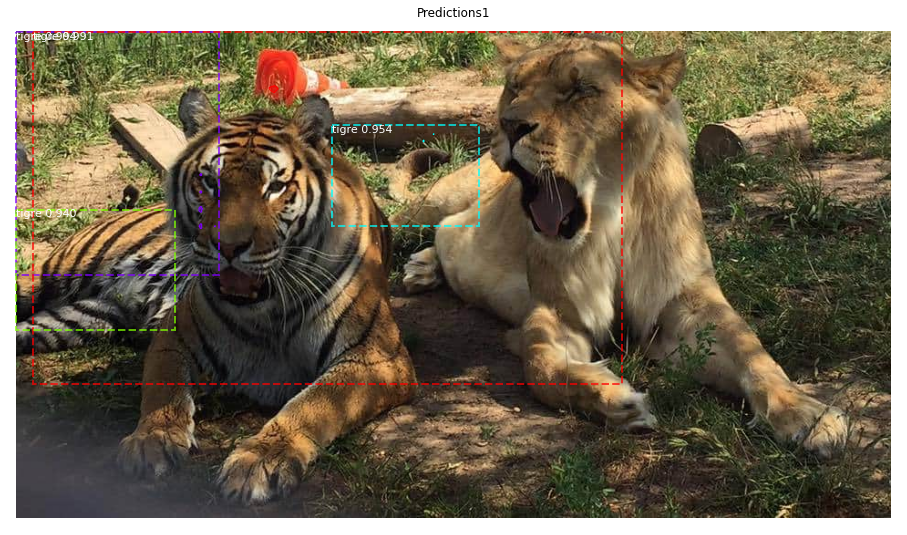

In [14]:
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

# This is for predicting images which are not present in dataset
path_to_new_image = "C:\M1 MASERTI\GPIA\IA\environnement_virtuel\Mask_RCNN-master\img_test\image1.jpg"
image1 = mpimg.imread(path_to_new_image)

# Run object detection
#print(len([image1]))
results1 = model.detect([image1], verbose=1)

# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")